In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rotate

In [2]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

In [38]:
def collate_fn_with_prints(batch):
    """"
    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    print("Here is the batch in `collate_fn`")
    print(batch)
    print("List of Tensor sizes in batch:")
    print([tensor.shape for tensor in batch])

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]

    batch_size = len(batch)


    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, 180)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], 180)
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], 180)
        
    return images_batch

In [39]:
(1, *[3, 4])

(1, 3, 4)

# Toy Data Experimentation

In [40]:
images = torch.randn(5, 1, 3, 3)
dataset = ImageDataset(images)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn_with_prints, shuffle=True)

for batch in dataloader:
    batch = batch.view(batch.shape[0]*batch.shape[1], *batch.shape[2:]) 
    print(f"Batch output w/ shape {batch.shape}")
    print(batch)
    print("\n\n")

Here is the batch in `collate_fn`
[tensor([[[-1.1209, -0.6277, -0.9731],
         [-1.2638, -0.0426,  1.4121],
         [ 1.4487,  1.3050,  0.7169]]]), tensor([[[-1.3475, -0.1817,  2.0761],
         [-0.8000, -0.2435, -0.0840],
         [-1.4464, -0.0604, -0.2368]]])]
List of Tensor sizes in batch:
[torch.Size([1, 3, 3]), torch.Size([1, 3, 3])]
Batch size: 2
Batch output w/ shape torch.Size([6, 1, 3, 3])
tensor([[[[-1.1209, -0.6277, -0.9731],
          [-1.2638, -0.0426,  1.4121],
          [ 1.4487,  1.3050,  0.7169]]],


        [[[ 0.7169,  1.3050,  1.4487],
          [ 1.4121, -0.0426, -1.2638],
          [-0.9731, -0.6277, -1.1209]]],


        [[[-1.3475, -0.1817,  2.0761],
          [-0.8000, -0.2435, -0.0840],
          [-1.4464, -0.0604, -0.2368]]],


        [[[-1.3475, -0.1817,  2.0761],
          [-0.8000, -0.2435, -0.0840],
          [-1.4464, -0.0604, -0.2368]]],


        [[[-0.2368, -0.0604, -1.4464],
          [-0.0840, -0.2435, -0.8000],
          [ 2.0761, -0.1817, -

In [45]:
images.shape

torch.Size([5, 1, 3, 3])

# CelebA

In [46]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform)

    def __getitem__(self, index):
        path = self.imgs[index][0]
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img


In [47]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/CelebA", 'transform': transform}
celeba_data = CustomImageFolder(**train_kwargs)

In [48]:
len(celeba_data)

202599

In [52]:
BATCH_SIZE = 5

In [55]:
celeba_dataloader = DataLoader(celeba_data, batch_size=BATCH_SIZE, collate_fn=collate_fn_with_prints, shuffle=True)

In [67]:
def show_triplets_in_batch(dataloader: DataLoader):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(BATCH_SIZE, 3, figsize=(15, 15))

    batch = next(iter(dataloader))
    titles = ['Image 1', 'Augmented 1', 'Image 2']

    for batch_idx, triplet in enumerate(batch):
        for triplet_idx, image in enumerate(triplet):
            axs[batch_idx, triplet_idx].imshow(torch.permute(image, (1, 2, 0)))
            axs[batch_idx, triplet_idx].set_title(titles[triplet_idx])

    fig.suptitle(f'Batch of {BATCH_SIZE} Triplets')

    plt.show()


Here is the batch in `collate_fn`
[tensor([[[0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0706, 0.0667],
         [0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0706, 0.0667],
         [0.0824, 0.0824, 0.0824,  ..., 0.0706, 0.0706, 0.0667],
         ...,
         [0.0510, 0.0471, 0.0471,  ..., 0.3529, 0.3412, 0.3294],
         [0.0471, 0.0510, 0.0549,  ..., 0.3490, 0.3373, 0.3216],
         [0.0471, 0.0549, 0.0627,  ..., 0.3451, 0.3216, 0.2941]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0157, 0.0118, 0.0039,  ..., 0.3255, 0.3216, 0.3059],
         [0.0078, 0.0078, 0.0078,  ..., 0.3255, 0.3216, 0.3059],
         [0.0039, 0.0039, 0.0078,  ..., 0.3216, 0.3020, 0.2863]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.007

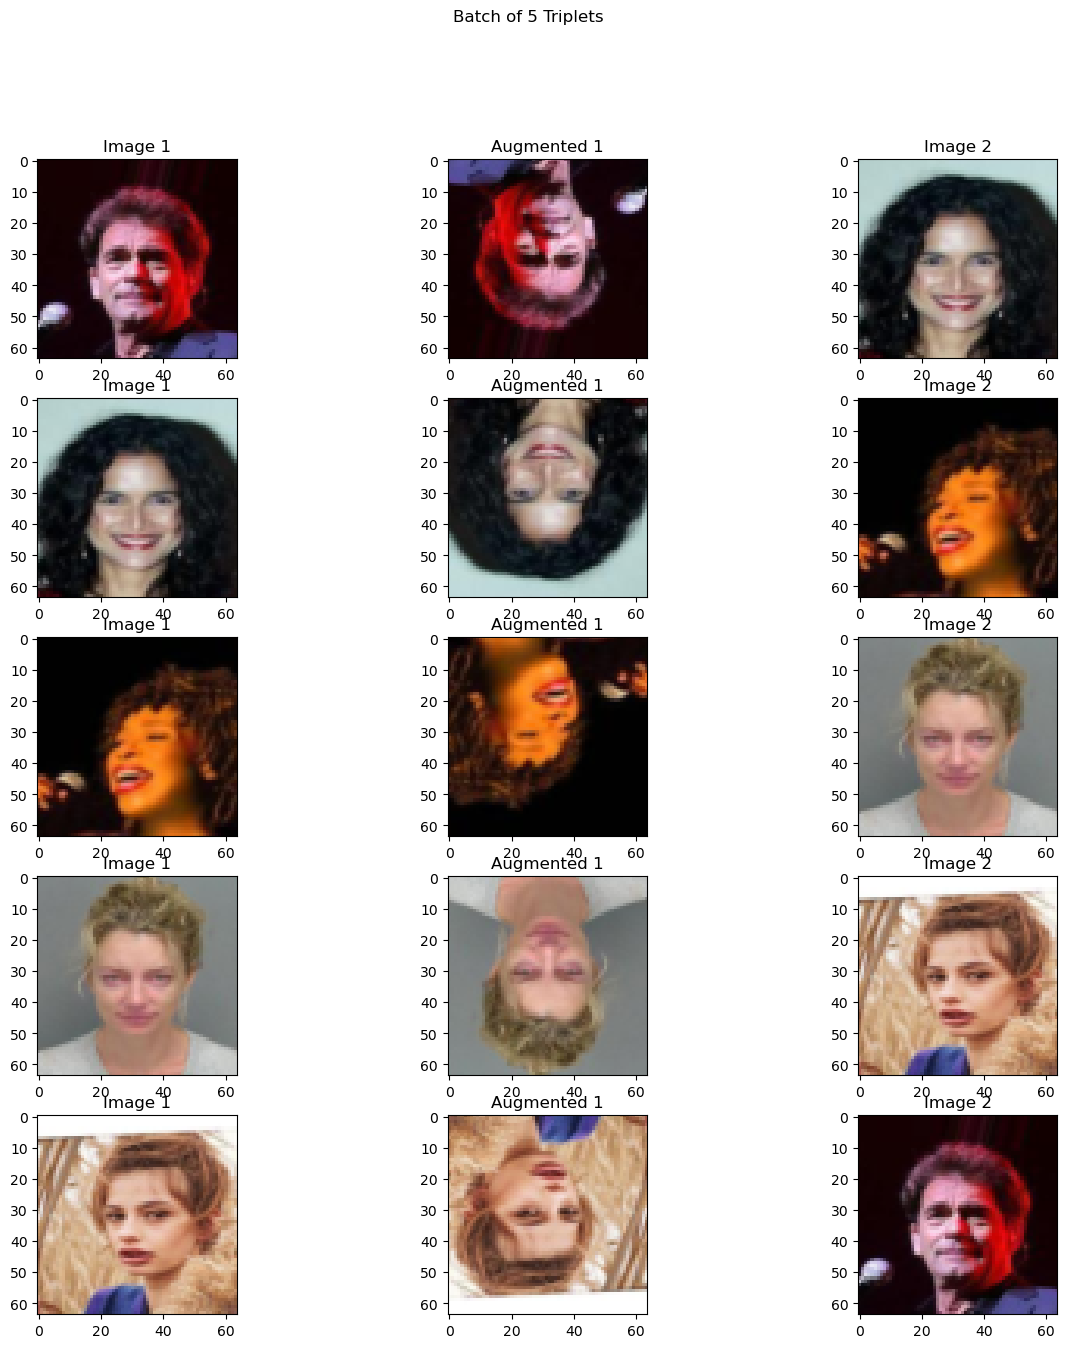

In [69]:
show_triplets_in_batch(celeba_dataloader)

# 3DChairs

In [70]:
def collate_fn(batch):
    """"
    Proccesses a batch of data sequentially (in the form) of a list
    to return a batch of triplets (one image, its augmentation, and another image)
    or a (one image, its augmentation) pair 
    
    Keyword arguments:
    batch -- a list of images, its length is batch_size
    Return: Tensor with shape (batch_size, 3 or 2, num_channels, height, width)
    """

    # get image dimensions, assuming all images are the same size
    # and it is number-of-channels (nc) first
    nc, h, w = batch[0].shape[-3], batch[0].shape[-2], batch[0].shape[-1]
    batch_size = len(batch)

    """to return batches of 3 (original image, augmented original, and another image)
    implies we need at least two separate images to work off of""" 
    if batch_size >= 2:
        print(f"Batch size: {batch_size}")
        # format: (batch_size, 3 for (original, augmented, another), num_channels, height, width)
        images_batch = torch.zeros((batch_size, 3, nc, h, w))
        
        for i in range(batch_size - 1):         
            first_image_index = i
            second_image_index = i + 1 # can be i and i + 1 if we toggle shuffle = True, so that it's random
            first_image = batch[first_image_index]
            second_image = batch[second_image_index]
            first_image_augmented = rotate(first_image, 180)

            images_batch[i, 0, :, :, :] = first_image
            images_batch[i, 1, :, :, :] = first_image_augmented
            images_batch[i, 2, :, :, :] = second_image
        
        images_batch[batch_size-1, 0, :, :, :] = batch[batch_size-1]
        images_batch[batch_size-1, 1, :, :, :] = rotate(batch[batch_size-1], 180)
        images_batch[batch_size-1, 2, :, :, :] = batch[0] 


    # otherwise, just create an (original image, augmented original) pair
    else:
        assert batch_size == 1
        images_batch = torch.zeros((batch_size, 2, nc, h, w))
        images_batch[0, 0, :, :, :] = batch[0]
        images_batch[0, 1, :, :, :] = rotate(batch[0], 180)
        
    return images_batch

In [71]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), ])

train_kwargs = {'root': "./data/3DChairs", 'transform': transform}
chairs3D_data = CustomImageFolder(**train_kwargs)

In [63]:
chairs3D_dataloader = DataLoader(chairs3D_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

Batch size: 5


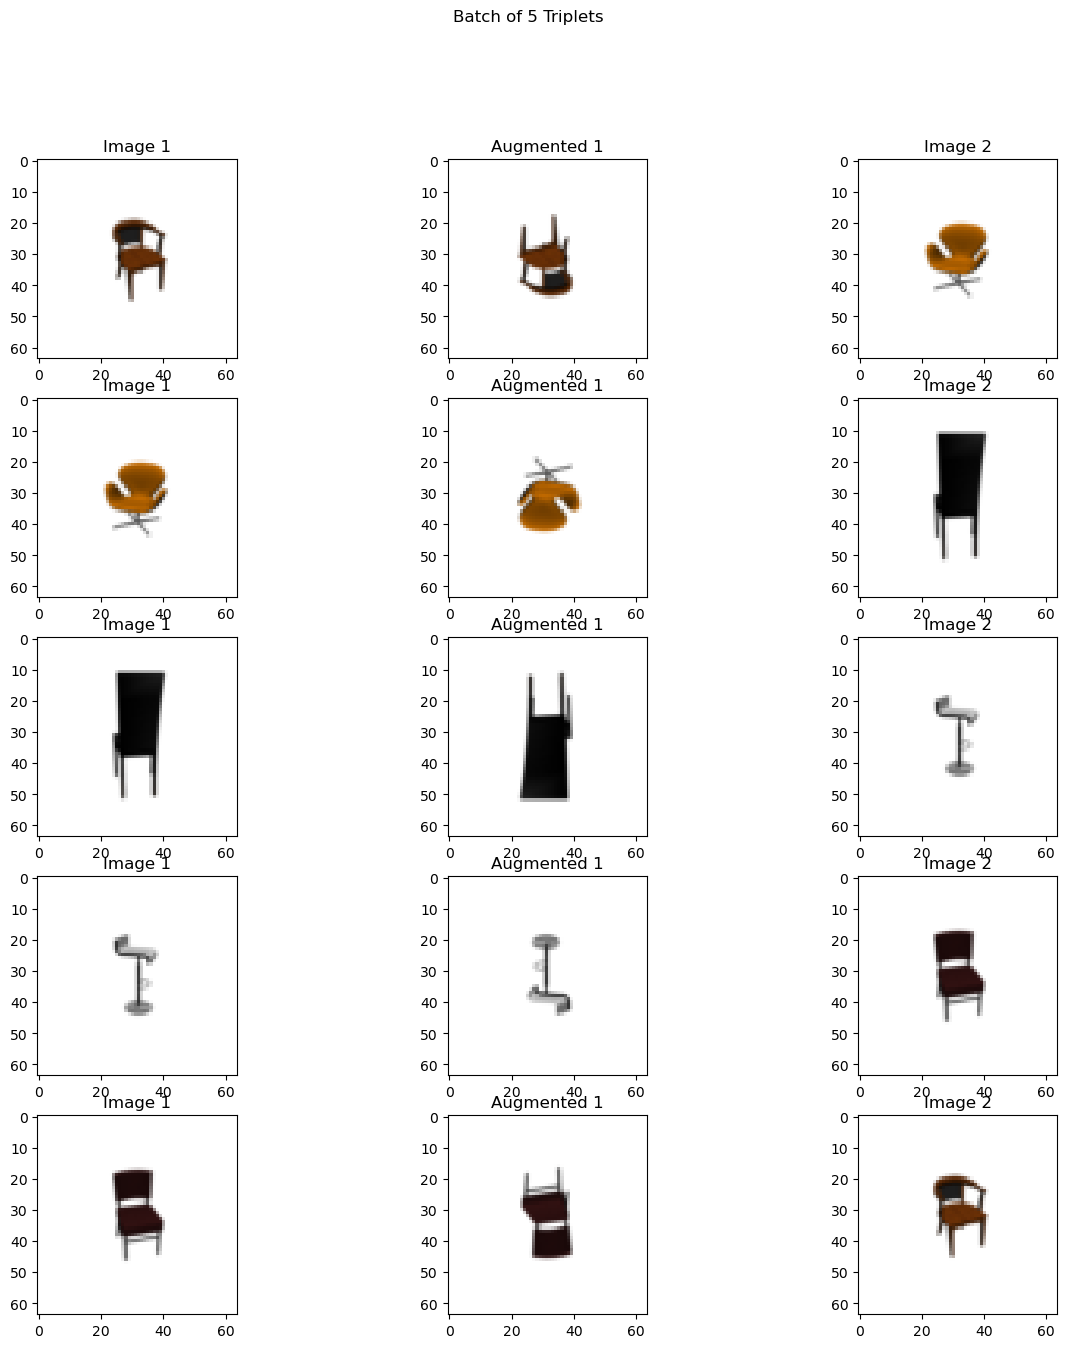

In [72]:
show_triplets_in_batch(chairs3D_dataloader)